In [27]:
import gymnasium as gym

from stable_baselines3 import PPO

from scipy.stats import norm
from src.rlmcmc.utils import Args, Toolbox
from src.rlmcmc.env import RLMHEnvV701

import matplotlib.pyplot as plt

import random
import numpy as np
import torch

from tqdm.auto import trange

In [2]:
log_p = lambda x: norm.logpdf(x, 0, 1)[0]

In [3]:
# env setup
args = Args()
args.seed = 1234
args.env_id = 'RLMHEnv-v7.0.1'

args.log_target_pdf = log_p
args.sample_dim = 1

args.total_timesteps = 100_000
args.batch_size = 32
args.learning_starts = args.batch_size
# args.learning_starts = 5_000
args.gamma = 0.99
# args.buffer_size = args.total_timesteps
args.learning_rate = 1e-6
args.policy_frequency = 2

random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = args.torch_deterministic

device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

envs = gym.vector.SyncVectorEnv(
    [
        Toolbox.make_env(

            env_id=args.env_id,
            seed=args.seed,
            log_target_pdf=args.log_target_pdf,
            sample_dim=args.sample_dim,
            total_timesteps=args.total_timesteps
        )
    ]
)

In [4]:
model = PPO(
    policy="MlpPolicy",
    env=envs,
    learning_rate=0.0003,
    n_steps=args.total_timesteps,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    clip_range_vf=None,
    normalize_advantage=True,
    ent_coef=0.0,
    vf_coef=0.5,
    max_grad_norm=0.5,
    use_sde=False,
    sde_sample_freq=-1,
    target_kl=None,
    stats_window_size=100,
    tensorboard_log=None,
    policy_kwargs={"net_arch": [64, 64]},
    verbose=0,
    seed=None,
    device="auto",
    _init_setup_model=True,
)

model.learn(total_timesteps=args.total_timesteps, log_interval=1, progress_bar=True)

/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/stable_baselines3/ppo/ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 100000`, after every 1562 untruncated mini-batches, there will be a truncated mini-batch of size 32
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=100000 and n_envs=1)
  warnings.warn(


Output()

/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/scipy/stats/_multivariate.py:117: 
RuntimeWarning: overflow encountered in scalar divide
  return np.array([0 if abs(x) <= eps else 1/x for x in v], dtype=float)

In [5]:
env = envs.unwrapped.envs[0].env.env.env
sample_list = np.array(env.store_sample)

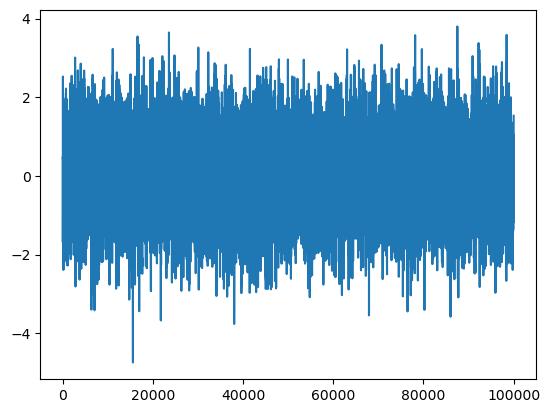

In [6]:
plt.plot(sample_list)

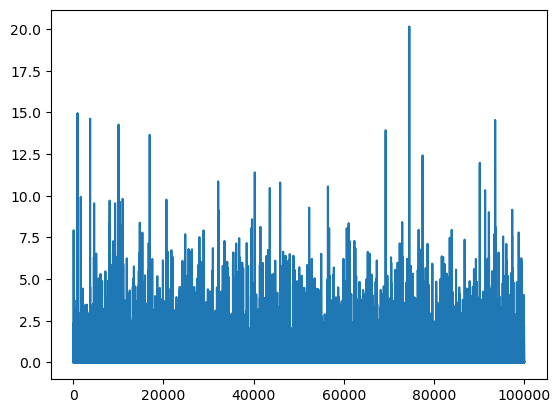

In [7]:
plt.plot(np.array(env.store_reward))
plt.show()

In [8]:
pred_envs = gym.vector.SyncVectorEnv(
    [
        Toolbox.make_env(

            env_id=args.env_id,
            seed=args.seed,
            log_target_pdf=args.log_target_pdf,
            sample_dim=args.sample_dim,
            total_timesteps=args.total_timesteps
        )
    ]
)

In [28]:
obs, _ = pred_envs.reset()

for _ in trange(5000):
    action, _ = model.predict(obs)
    obs, rewards, _, _, _ = pred_envs.step(action)

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/scipy/stats/_multivariate.py:117: RuntimeWarning: overflow encountered in scalar divide
  return np.array([0 if abs(x) <= eps else 1/x for x in v], dtype=float)


In [31]:
pred_env = pred_envs.unwrapped.envs[0].env.env.env
pred_sample_list = np.array(pred_env.store_sample)

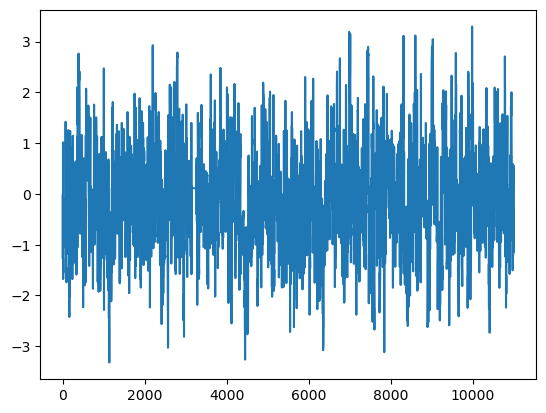

In [32]:
plt.plot(pred_sample_list)

In [33]:
np.sum(pred_env.store_accetped_status) / 5000

0.3946

In [44]:
x = np.linspace(-10, 10, 1000).reshape(-1, 1)
y = np.array([model.predict(i.reshape(1, 1))[0] for i in x]).reshape(-1, 2)

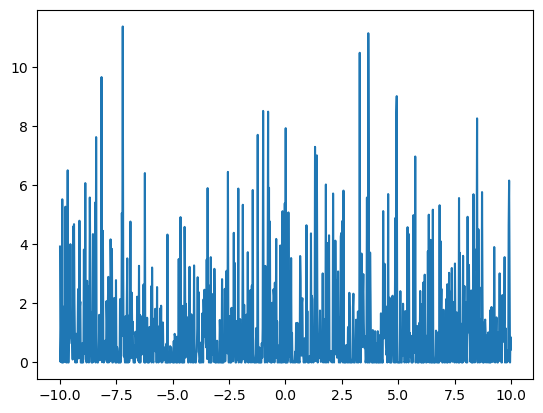

In [48]:
plt.plot(x, y[:, 0]**2 + y[:, 1]**2)